<a href="https://colab.research.google.com/github/theaveas/DeepLearning/blob/main/DLwithPython/chapter09_advanced_dl_for_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Deep Learning for Computer Vision
- The different branches of computer vision: *image classification*, *image segmentation*, *object detection*
- Modern convnet architecture patterns : *residual conddections*, *batch normalization*, *depthwise separable convolution*
- Techniques for *visualizing* and *interpreting* what convnets learn

**Image classification**: What we take a look at previous chapter. A task for computer to classify an image an categoria into the correct labels.
- Single-label classification, multi-label classification. [more about Image classification](https://github.com/theaveas/DeepLearning/blob/main/DLwithPython/chapter08_introduction_to_dl_for_cv.ipynb)
**Image segmentation** The goal is to `segment` or `partition` an image into different areas, witheach area usually representing a category.
- Semantic seqmentation
- Instance segmentation
**Object detection** A task for a computer to draw a rectangle around objects of interest in an image, and associate each rectangle with class.

## An Image segmentation

If `!wget command not found` [try this](https://www.jcchouinard.com/wget/)

In [ ]:
# download the dataset

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

# unzip file
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz



In [ ]:
# prepare file with corresponding images
import os

inputs_dir = 'images'
target_dir = 'annotations/trimaps'

input_image_paths = sorted(
    [os.path.join(inputs_dir, fname) for fname in os.listdir(inputs_dir) if fname.endswith('.jpg')]
)

target_image_paths = sorted(
    [os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.png') and not fname.startswith('.')]
)

In [ ]:
# preview the dataset

# import
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# load_img -> load image into PIL formart
# img_to_array -> convert PIL image instance into np array

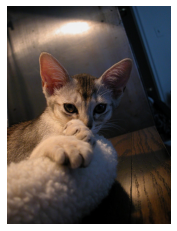

In [ ]:
plt.axis('off')
plt.imshow(load_img(input_image_paths[1]))

In [ ]:
# display segment image
def display_image(target_array):
    normalized_array = (target_array.astype('uint8')-1) * 127 # 
    plt.axis('off')
    plt.imshow(normalized_array[:, :, 0])

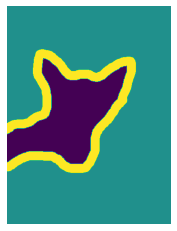

In [ ]:
image = img_to_array(load_img(target_image_paths[1], color_mode='grayscale'))
display_image(image)

In [ ]:
# load image and target data to numpy array
import numpy as np
import random

img_size = (224, 224)
num_imgs = len(input_image_paths)

# shuffle the file paths * use the same seed in both statements to ensure that the input and target paths stay in the same other
random.Random(42).shuffle(input_image_paths)
random.Random(42).shuffle(target_image_paths)

In [ ]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype('uint8')-1
    return img

In [ ]:
# load all images in the input images float32 array and the mask into uint8 array
input_imgs = np.zeros((num_imgs,)+ img_size + (3, ), dtype='float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')

In [ ]:
print(f'Input images shape: {input_imgs.shape}')
print(f'Target images shape: {targets.shape}')      

Input images shape: (7390, 224, 224, 3)
Target images shape: (7390, 224, 224, 1)


In [ ]:
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_image_paths[i])
    targets[i] = path_to_target(target_image_paths[i])

In [ ]:
# take 1000 sampe for validation
nums_val_sample = 1000

train_inputs_imgs = input_imgs[: - nums_val_sample]
train_targets = targets[: -nums_val_sample]
valid_inputs_imgs = input_imgs[-nums_val_sample :]
valid_targets = targets[-nums_val_sample :]

### Build and Train an Image segmentation model

In [ ]:
# import 
from tensorflow import keras
from keras.layers import Input, Rescaling, Conv2D, Conv2DTranspose

In [ ]:
def build_model(image_size, num_classes):
    inputs = Input(shape=(224, 224, 3))
    x = Rescaling(1./ 255)(inputs)
    
    x = Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(x)    
    x = Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)   
    x = Conv2D(filters=256, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x) 
    
    x = Conv2DTranspose(filters=256, kernel_size=3, strides=2, activation='relu', padding='same')(x)  
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, activation='relu', padding='same')(x)  
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)  
    
    outputs = Conv2DTranspose(filters=num_classes, kernel_size=3, activation='softmax', padding='same')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
model = build_model(img_size, num_classes=3)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 256)       2951

In [ ]:
(200, 200) + (3,)

(200, 200, 3)

In [ ]:
model.compile(
    optimizer = 'rmsprop',
    loss = 'sparse_categorical_crossentropy'
    )


hist = model.fit(train_inputs_imgs, train_targets, 
                 epochs=50, 
                 batch_size=64, 
                 validation_data=(valid_inputs_imgs, valid_targets))

Epoch 1/50


2022-03-25 21:52:38.667351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.4544

2022-03-25 21:55:07.154092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 159s 2s/step - loss: 1.4544 - val_loss: 0.8906
Epoch 2/50
  5/100 [>.............................] - ETA: 2:21 - loss: 0.9116

KeyboardInterrupt: 

### Residual model architecture

In [ ]:
# import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
residual = x # set aside the residual
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual]) # both x and residual must have the same shape

2022-03-28 21:09:01.759707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-28 21:09:01.760344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [ ]:
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding='same')(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_3 (Rescaling)        (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_3[0][0]']            
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_17[0][0]']              
                                                                                              

## Xception like model
Deep learning model best practice
- model should be organized into repeated blocks of layers, made of multiple conv-layer and max-pooling layer
- the number of filters in layers should be increase as the size of the spatial feature maps decrease
- deep and narrow is better than wild and shallow
- introducing residual connections around blocks to prevent vanish gd
- can be beneficial to use batch normalization after conv layers
- can be beneficial to replace conv2d to separableconv2d layers which are more parameter-efficient

In [ ]:
# import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Rescaling, Input, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D, Dropout, Activation, Dense

In [ ]:
# xception
inputs = Input(shape=(224, 224, 3))

x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=size, kernel_size=3, padding='same', use_bias=False)(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(filters=size, kernel_size=3, padding='same', use_bias=False)(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(filters=size, kernel_size=1, strides=2, padding='same', use_bias=False)(residual)
    residual = BatchNormalization()(residual)
    
    x = layers.add([x, residual])
    
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 220, 220, 32  2400        ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
# xception
inputs = Input(shape=(224, 224, 3))

x = Rescaling(1./255)(inputs)
x = Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=size, kernel_size=3, padding='same', use_bias=False)(x)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=size, kernel_size=3, padding='same', use_bias=False)(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(filters=size, kernel_size=1, strides=2, padding='same', use_bias=False)(residual)
    residual = BatchNormalization()(residual)
    
    x = layers.add([x, residual])
    
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
outputs = Dense(units=1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 220, 220, 32  2400        ['rescaling_6[0][0]']            
                                )                                                                 
                                                                                            

## Visualizing ConvNet
**Visualizing Intermediate activations**

In [ ]:
model = keras.models.load_model('convnet_from_scratch.keras')

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 109, 109, 64)      18496     
                                                           